### Попытка понять, как делить отрезок \[0, 1\] на части

Предположим, что мы делим изоляционным деревом массив одномерных данных.
Если при этом мы хотим оценить плотность вероятности [?], то ветвление производим
по порогу, выбранному случайным образом от 0 до 1. Вне зависимости от реальных
значений семплов.

Этот подход расходится с тем, как делается в изоляционном лесе, где порог выбирается
случайным образом между минимуом m и максимумом M, т.е. на отрезке \[m, M\].

Вопрос -- как совместить эти два подхода? Чтобы и плотность вероятности
оценить можно было, и учесть распределение данных.

Идея -- сделаем ветвление чуть сложнее, чем в изоляционном лесе. Представим, что мы
ветвимся случайным образом, не глядя на данные, до тех пор, пока не попадём в сами
данные. Более строго -- ветвимся по отрезку \[0, 1\], пока не попадём в \[m, M\].

Понятно, что таким образом мы разделим отрезок либо на две, либо на три, либо на
четыре части. На две разделим, если попадём в \[m, M\] сразу. На три поделим, если сперва
будем ветвиться в одну сторону всё время, и только потом попадём в отрезок \[m, M\]. А на
четыре поделим, если сперва будем ветвиться в разные стороны, а в конце попадём в отрезок
\[m, M\].

Таким образом имеем разбиение отрезка \[0, 1\] на четыре фрагмента в общем случае.
Точки концов отрезков обозначим 0, l, m, t, M, L, 1. Здесь t -- итоговый порог, а точки
l и L -- это максимальный и минимальный пороги при правом и левом ветвлении, когда
случайное число попадает мимо отрезка \[m, M\]. Потенциально l и L могут быть равны
0 и 1, соответственно. В том случае, когда соответствующих ветвлений не происходит.

Получается, что порог t мы выбрали по точно таким же принципам, как это сделано
в изоляционном лесе, т.е. из равномерного распределения на носителе \[m, M\]. Но при этом
мы так же получили ещё два числа: l и L, которые задают границы. За этими границами
плотность распределения следует оценивать как 0. Что прямо соответствует статье [?].

После всего сказанно остаётся ответить на вопрос -- можно ли получить те же границы
l и L совместно с порогом t без лишних действий? Просто выбрав их из каких-то распределений.
Только распределения следует подобрать так, чтобы модель была статистически эквивалентной
рассмотренному здесь алгоритму.

Вот поиском этой модели мы и займёмся в этой тетради.

In [1]:
using Plots
using Statistics

In [2]:
function sample_ends(m::Float64, M::Float64; depth::Int=-1, short::Bool=false)
    t = rand(Float64)
    
    if short
        x = max(M - (M - m) / rand(Float64), 0)
        y = (x == 0) ? (M / rand(Float64)) : ((M - x) / sqrt(rand(Float64)) + x)
        return (M - m) * t + m, x, 0.0, min(y, 1), 0.0
    end
    
    if depth == 0
        return (M - m) * t + m, 0.0, 0.0, 1.0, 0.0
    end

    if t < m
        x, y, yn, z, zn = sample_ends((m - t) / (1 - t), (M - t) / (1 - t); depth=depth-1)
        x * (1 - t) + t, y * (1 - t) + t, yn + 1.0, z * (1 - t) + t, zn
    elseif t > M
        x, y, yn, z, zn = sample_ends(m / t, M / t; depth=depth-1)
        x * t, y * t, yn, z * t, zn + 1.0
    else
        t, 0.0, 0.0, 1.0, 0.0
    end
end


function sample_ends(m::Float64, M::Float64, n::Int64; depth::Int=-1, short::Bool=false)
    samples = Array{Float64}(undef, 5, n)
    for i in range(1, n)
        samples[:, i] .= sample_ends(m, M; depth=depth, short=short)
    end
    samples
end


function beta_estimate(x)
    x_mean = mean(x)
    x_var = var(x; corrected=false, mean=x_mean)
    nu = x_mean * (1 - x_mean) / x_var - 1
    (x_mean * nu, (1 - x_mean) * nu)
end

beta_estimate (generic function with 1 method)

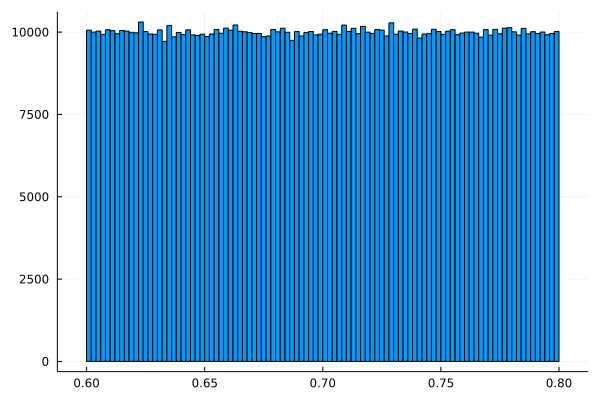

In [3]:
# Проверяем, что на [m, M] распределение действительно получилось равномерным

samples = sample_ends(0.6, 0.8, 1000000)
histogram(samples[1, :], label=nothing)

0.599296

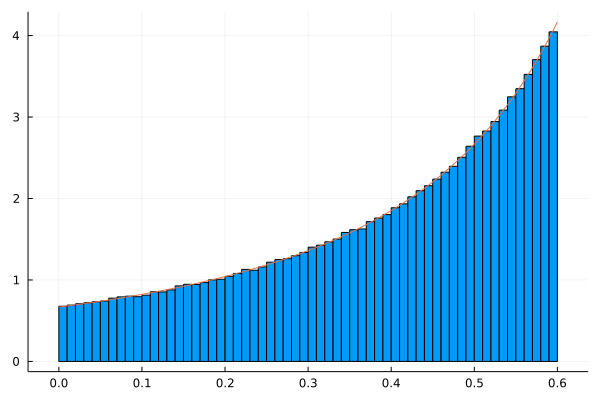

In [4]:
# Вероятность распределиться и плотность распределения

samples = sample_ends(0.6, 1.0, 1000000)

lefts = filter(p -> p != 0, samples[2, :])
display(size(lefts, 1) / size(samples, 2))

p = histogram(lefts, label=nothing, normalize=true)
begin
    t = range(0, 0.6, 100)
    plot!(p, t, @.(0.4 / 0.6 / (1 - t)^2), label=nothing)
end

0.399324

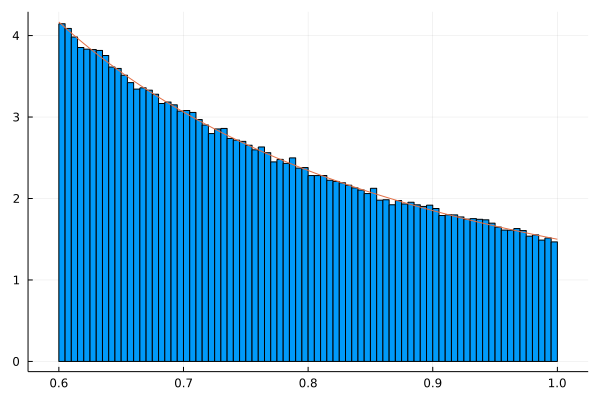

In [5]:
# Вероятность распределиться и плотность распределения

samples = sample_ends(0.0, 0.6, 1000000)

rights = filter(p -> p != 1, samples[4, :])
display(size(rights, 1) / size(samples, 2))

p = histogram(rights, label=nothing, normalize=true)
begin
    t = range(0.6, 1.0, 100)
    plot!(p, t, @.(0.6 / 0.4 / t^2), label=nothing)
end

0.75001

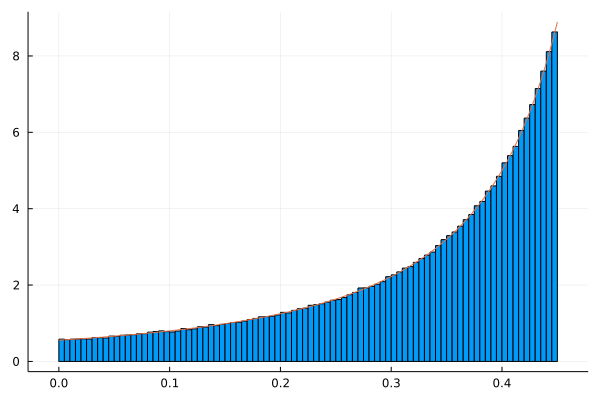

In [6]:
# Вероятность распределиться и плотность распределения

xi = 0.55
eta = 0.6
samples = sample_ends(1 - xi, eta, 1000000, short=true)

lefts = samples[:, samples[2, :] .!= 0][2, :]
display(size(lefts, 1) / size(samples, 2))

p = histogram(lefts, label=nothing, normalize=true)
begin
    t = range(0, 1 - xi, 100)
    k = 1 / (xi + eta - 1) - 1 / eta
    plot!(p, t, @.(1 / (eta - t)^2 / k) , label=nothing)
end

0.749824

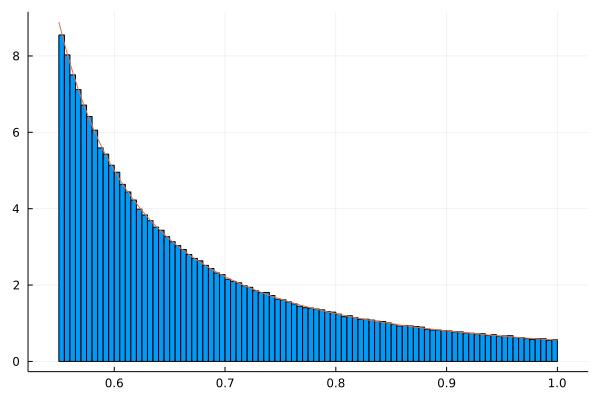

In [7]:
# Вероятность распределиться и плотность распределения

xi = 0.6
eta = 0.55
samples = sample_ends(1 - xi, eta, 1000000, short=true)

rights = samples[:, samples[4, :] .!= 1][4, :]
display(size(rights, 1) / size(samples, 2))

p = histogram(rights, label=nothing, normalize=true)
begin
    t = range(eta, 1, 100)
    k = 1 / (xi + eta - 1) - 1 / xi
    plot!(p, t, @.(1 / (xi - 1 + t)^2 / k) , label=nothing)
end

In [8]:
using HypothesisTests

In [9]:
ApproximateTwoSampleKSTest(lefts, 1 .- rights)

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00183418

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1604

Details:
    number of observations:   [750010,749824]
    KS-statistic:              1.1231377550967951


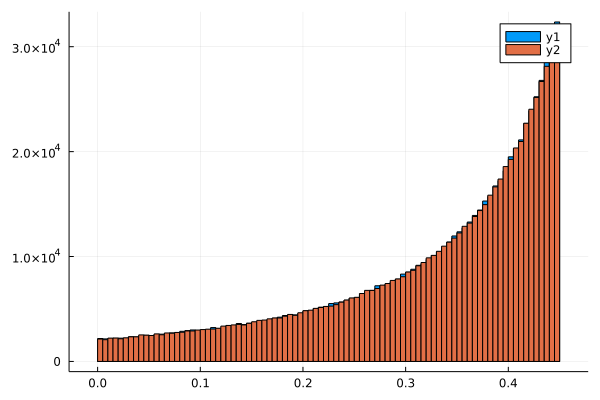

In [10]:
p = histogram(lefts)
histogram!(p, 1 .- rights)

### Как можно этим воспользоваться?

Попробуем оценить плотность распределения по парным наблюдениям.

In [246]:
function sample_interval(a::Float64, b::Float64; left::Float64=-Inf, right::Float64=Inf, simplified::Bool=true)
    #(a, b) = (a > b) ? (b, a) : (a, b)

    if simplified
        x = b - (b - a) / rand(Float64)
        y = (b - x) / sqrt(rand(Float64)) + x
        return max(x, left), min(y, right)
    else
        x = max(b - (b - a) / rand(Float64), left)
        y = (x == left) ? ((b - left) / rand(Float64) + left) : ((b - x) / sqrt(rand(Float64)) + x)
        return x, min(y, right)
    end
end


function sample_interval(a::Float64, b::Float64, n::Int; kwargs...)
    result = Array{Float64}(undef, 2, n)
    
    for i in range(1, n)
        result[:, i] .= sample_interval(a, b; kwargs...)
    end
    
    return result
end

sample_interval (generic function with 2 methods)

#### Проверим, что simplified действительно можно пользоваться

In [89]:
left = -4.0
right = 3.0

fst_sample = sample_interval(0.0, 1.0, 400000; left=left, right=right, simplified=false)
snd_sample = sample_interval(0.0, 1.0, 400000; left=left, right=right, simplified=true)

2×400000 Matrix{Float64}:
 -1.40956  -0.132395  -0.195624  …  -4.0  -4.0  -0.420498  -0.612989
  3.0       1.63088    3.0           3.0   3.0   1.2075     1.39698

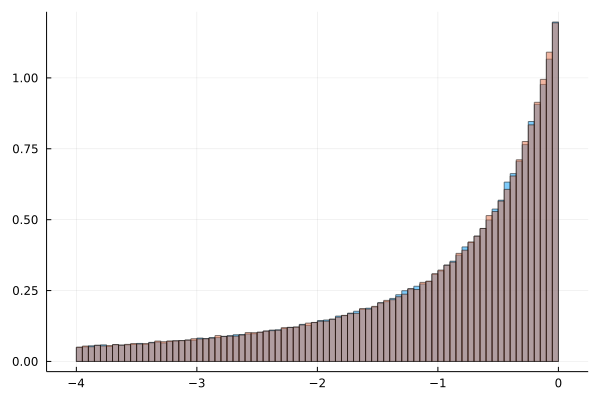

In [91]:
p1 = histogram(fst_sample[1, fst_sample[1, :] .!= -4], alpha=0.5, normalize=:pdf, label=nothing)
histogram!(p1, snd_sample[1, snd_sample[1, :] .!= -4], alpha=0.5, normalize=:pdf, label=nothing)

In [92]:
ApproximateTwoSampleKSTest(fst_sample[1, fst_sample[1, :] .!= -4], snd_sample[1, snd_sample[1, :] .!= -4])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00287784

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.1412

Details:
    number of observations:   [320231,319722]
    KS-statistic:              1.1510919663928698


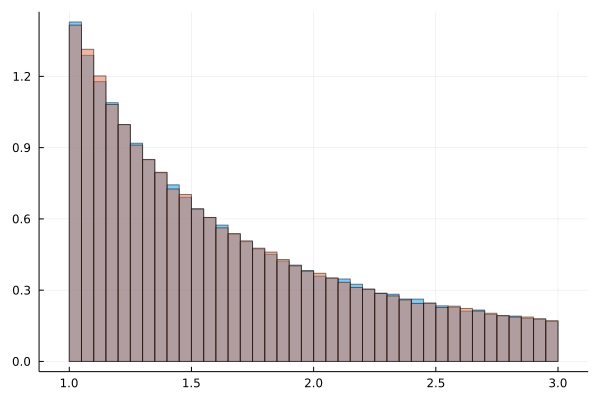

In [93]:
p2 = histogram(fst_sample[2, fst_sample[2, :] .!= 3], alpha=0.5, normalize=:pdf, label=nothing)
histogram!(p2, snd_sample[2, snd_sample[2, :] .!= 3], alpha=0.5, normalize=:pdf, label=nothing)

In [95]:
ApproximateTwoSampleKSTest(fst_sample[2, fst_sample[2, :] .!= 3], snd_sample[2, snd_sample[2, :] .!= 3])

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.00220389

Test summary:
    outcome with 95% confidence: fail to reject h_0
    two-sided p-value:           0.5373

Details:
    number of observations:   [266246,266367]
    KS-statistic:              0.8042033458694465


#### Алгоритм оценки pdf

In [334]:
function estimate_density(samples::AbstractArray{Float64}, points::Vector; method::Symbol=:new, left::Float64=-Inf, right::Float64=Inf, power::Float64=-1.0)
    samples = reshape(samples, 2, :)
    n = size(samples, 2)
    for i in range(1, n)
        x, y = samples[:, i]
        (x, y) = (x > y) ? (y, x) : (x, y)
        samples[:, i] .= (x, y)
    end
    
    intervals = Array{Float64}(undef, size(samples))
    if method == :new
        for i in range(1, n)
            intervals[:, i] .= sample_interval(samples[1, i], samples[2, i]; left=left, right=right)
        end
    else
        intervals = samples
    end

    heights = Array{Float64}(undef, n)
    @.(heights = (samples[2, :] - samples[1, :]) ^ power)

    values = zeros(Float64, length(points))
    for i in range(1, length(values))
        x = points[i]
        values[i] += sum((intervals[1, :] .< x) .& (x .< intervals[2, :]) .* heights)
    end
    
    return values ./ n
end

estimate_density (generic function with 2 methods)

In [258]:
using Random, Distributions

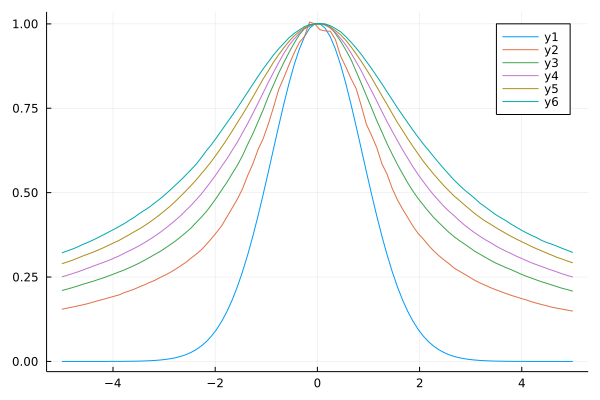

In [355]:
d = Normal()
samples = rand(d::Distribution, 100000)

xs = collect(range(-5, 5, 100))
i = length(xs) ÷ 2

ys = cdf.(d, xs)
ys = ys .* (1 .- ys) #pdf.(d, xs)
p = plot(xs, ys ./ ys[i])
for power in [-1, -0.5, 0, 0.5, 1]
    ys = estimate_density(samples, xs; method=:new, power=power)
    plot!(p, xs, ys ./ ys[i])
end

#xlims!(p, (1, 3))

p

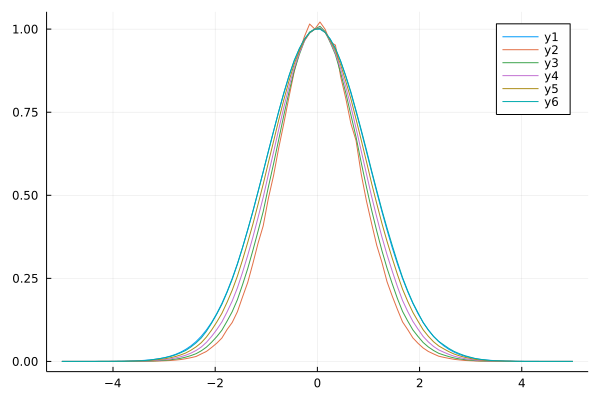

In [357]:
d = Normal()
samples = rand(d::Distribution, 100000)

xs = collect(range(-5, 5, 100))
i = length(xs) ÷ 2

ys = pdf.(d, xs)
p = plot(xs, ys ./ ys[i])
for power in [-1, -0.5, 0, 0.5, 1]
    ys = estimate_density(samples, xs; method=:old, power=power)
    plot!(p, xs, ys ./ ys[i])
end

#xlims!(p, (1, 3))

p

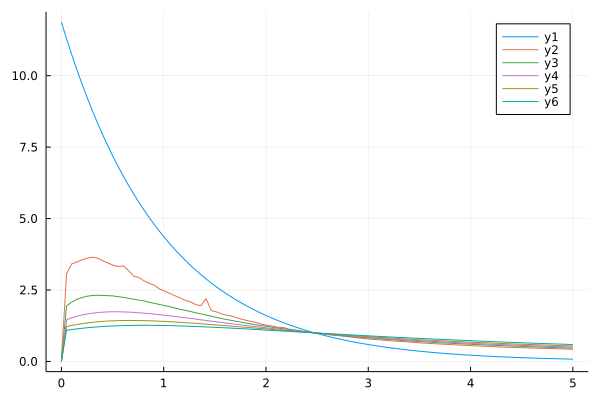

In [359]:
d = Exponential()
samples = rand(d::Distribution, 100000)

xs = collect(range(0, 5, 100))
i = length(xs) ÷ 2

ys = pdf.(d, xs)
p = plot(xs, ys ./ ys[i])
for power in [-1, -0.5, 0, 0.5, 1]
    ys = estimate_density(samples, xs; method=:new, power=power, left=0.0)
    plot!(p, xs, ys ./ ys[i])
end

#xlims!(p, (1, 3))

p

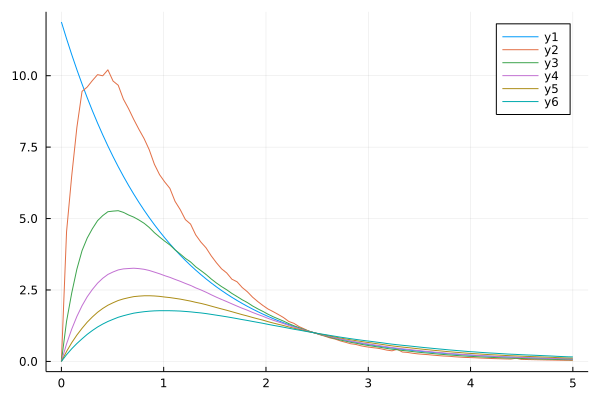

In [361]:
d = Exponential()
samples = rand(d::Distribution, 100000)

xs = collect(range(0, 5, 100))
i = length(xs) ÷ 2

ys = pdf.(d, xs)
p = plot(xs, ys ./ ys[i])
for power in [-1, -0.5, 0, 0.5, 1]
    ys = estimate_density(samples, xs; method=:old, power=power, left=0.0)
    plot!(p, xs, ys ./ ys[i])
end

#xlims!(p, (1, 3))

p

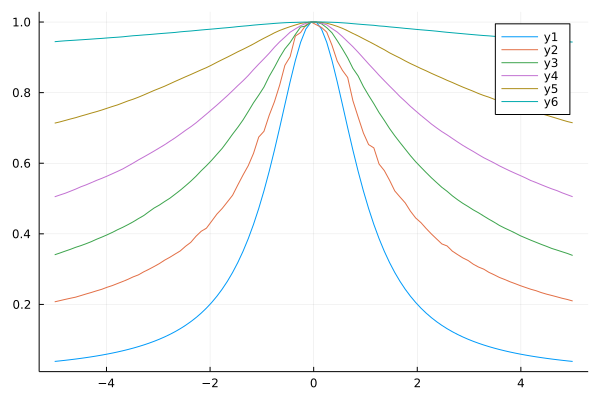

In [337]:
d = Cauchy()
samples = rand(d::Distribution, 100000)

xs = collect(range(-5, 5, 100))
i = length(xs) ÷ 2

ys = pdf.(d, xs)
p = plot(xs, ys ./ ys[i])
for power in [-1, -0.5, 0, 0.5, 1]
    ys = estimate_density(samples, xs; method=:new, power=power)
    plot!(p, xs, ys ./ ys[i])
end

#xlims!(p, (1, 3))

p

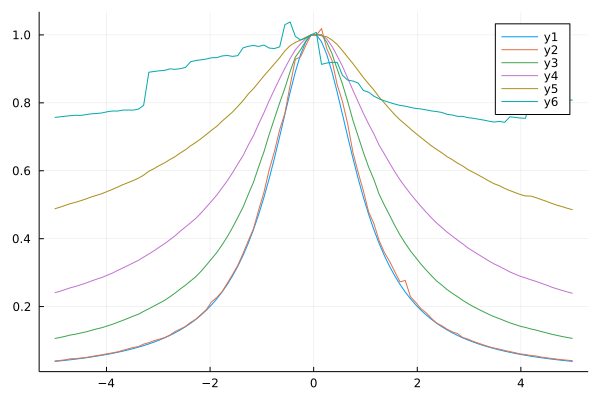

In [354]:
d = Cauchy()
samples = rand(d::Distribution, 100000)

xs = collect(range(-5, 5, 100))
i = length(xs) ÷ 2

ys = pdf.(d, xs)
p = plot(xs, ys ./ ys[i])
for power in [-1, -0.5, 0, 0.5, 1]
    ys = estimate_density(samples, xs; method=:old, power=power)
    plot!(p, xs, ys ./ ys[i])
end

#xlims!(p, (1, 3))

p

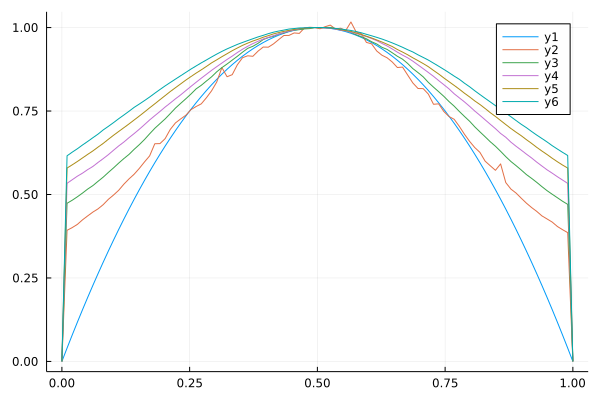

In [338]:
d = Beta(2, 2)
samples = rand(d::Distribution, 100000)

xs = collect(range(0, 1, 100))
i = length(xs) ÷ 2

ys = pdf.(d, xs)
p = plot(xs, ys ./ ys[i])
for power in [-1, -0.5, 0, 0.5, 1]
    ys = estimate_density(samples, xs; method=:new, power=power, left=0.0, right=1.0)
    plot!(p, xs, ys ./ ys[i])
end

#xlims!(p, (1, 3))

p

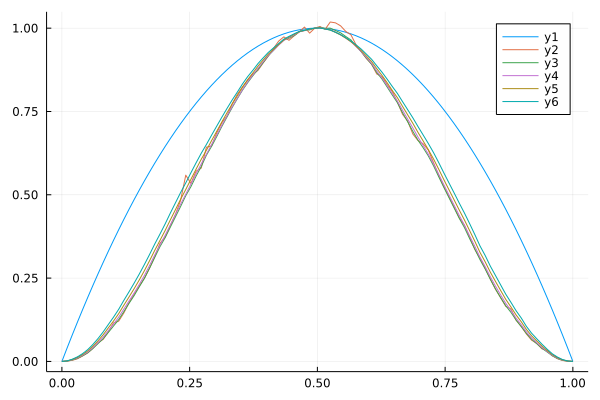

In [330]:
d = Beta(2, 2)
samples = rand(d::Distribution, 100000)

xs = collect(range(0, 1, 100))
i = length(xs) ÷ 2

ys = pdf.(d, xs)
p = plot(xs, ys ./ ys[i])
for power in [-1, -0.5, 0, 0.5, 1]
    ys = estimate_density(samples, xs; method=:old, power=power, left=0.0, right=1.0)
    plot!(p, xs, ys ./ ys[i])
end

#xlims!(p, (1, 3))

p